## The [Learnable Scriber](https://github.com/malamatenia/learnable-scriber) 📜, an adaptation of the [Learnable Typewriter](https://github.com/ysig/learnable-typewriter)📇 for script type morphological analysis.

### [Malamatenia Vlachou-Efstathiou](https://ephe.academia.edu/MalamateniaVlachouEfstathiou) [Yannis Siglidis](https://imagine.enpc.fr/~siglidii/), [Dominique Stutzmann](https://cv.hal.science/dominique-stutzmann) [Mathieu Aubry](http://imagine.enpc.fr/~aubrym/)  
### IRHT (https://www.irht.cnrs.fr/), _Institut de Recherche et d'Histoire des Textes, CNRS_ [Imagine](https://imagine.enpc.fr/), _LIGM, Ecole des Ponts, Univ Gustave Eiffel, CNRS, Marne-la-Vallée, France_

![LTW_graph.png](https://raw.githubusercontent.com/malamatenia/learnable-scriber/main/.media/LTW_graph.png)

## Purpose of the notebook : Perform minimal inference from trained and finetuned models.

## Install 🧰

We first clone and install the dependencies of the learnable-typewriter repository (**requires restart**).

In [ ]:
import os
if not os.path.isdir('learnable-scriber'):
    !git clone --quiet https://github.com/malamatenia/learnable-scriber.git
%cd /content/learnable-scriber
!pip install -r requirements.txt --quiet
!pip install wandb --quiet

/content/learnable-scriber
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 787.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


## Imports 📥

In [ ]:
!rm -rf runs/ datasets/
!wget 'https://www.dropbox.com/scl/fi/sxvejr12pg3b0bq4f1sj0/demo.zip?rlkey=24m4dggyvpfa558u5bmq7xew9&st=0slmvjqi&dl=0' -O demo.zip &> /dev/null
!unzip -q demo.zip -d . &> /dev/null
!rm demo.zip

In [ ]:
!rm -rf __MACOSX

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
from os.path import abspath, join
from pathlib import Path
from omegaconf import OmegaConf
from IPython.display import display, display_markdown
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

import ipywidgets as widgets
from IPython.display import display as ipy_display, clear_output

PARENT = abspath('')
RUNS = join(PARENT, "runs/")
sys.path.append(PARENT)

In [ ]:
from learnable_typewriter.utils.loading import load_pretrained_model
from learnable_typewriter.typewriter.model import LearnableTypewriter
from learnable_typewriter.data.dataloader import collate_fn_pad_to_max

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


## Inference ⭐

As inference we denote the production of the following information out of a given input  𝑥 :

* Visual vocabulary of prototypes
* Reconstruction
* Semantic Segmentation

## Helper Functions

Using the decompositor module we can produce all the required reconstruction and semantic segmentation information.
To just obtain reconstruction we can also use the xp = model.predict_cell_per_cell(x) function.
Finally to infer the ground truth characters we use the trainer.inference(x, xp) module (where the second argument can be ommitted in the expense of recomputing it internally).

In [ ]:
def get_line(loader, idx):
    ds = loader[0].dataset[idx]
    x = collate_fn_pad_to_max([ds], supervised=True)
    return x

def inference_from_line(decompositor, x):
    obj = decompositor(x)
    gt, rec, sgm = [to_pil_image(a.cpu()[0]) for a in [x['x'], obj['reconstruction'], obj['segmentation']]]
    rec = to_pil_image(obj['reconstruction'].cpu()[0])
    sgm = to_pil_image(obj['segmentation'].cpu()[0])
    x_image = to_pil_image(x['x'].cpu()[0])
    return x_image, rec, sgm

def inference(trainer, idx):
    ds = trainer.train_loader[0].dataset[idx]
    x = collate_fn_pad_to_max([ds], supervised=True)

    obj = trainer.decompositor(x)
    gt, rec, sgm = [to_pil_image(a.cpu()[0]) for a in [x['x'], obj['reconstruction'], obj['segmentation']]]
    return gt, rec, sgm

In [ ]:
def display_inference(trainer, min_index=None, max_index=None):
    if min_index is None:
        min_index = 0
    if max_index is None:
        max_index = len(trainer.train_loader[0].dataset) - 1

    index_slider = widgets.IntSlider(min=min_index, max=max_index, step=1, description='Index:')

    output_gt = widgets.Output()
    output_rec = widgets.Output()
    output_sgm = widgets.Output()

    def on_index_change(change):
        idx = change['new']
        gt, rec, sgm = inference(trainer, idx)

        with output_gt:
            clear_output(wait=True)
            ipy_display(gt)

        with output_rec:
            clear_output(wait=True)
            ipy_display(rec)

        with output_sgm:
            clear_output(wait=True)
            ipy_display(sgm)

    initial_idx = min_index
    gt_initial, rec_initial, sgm_initial = inference(trainer, initial_idx)

    with output_gt:
        ipy_display(gt_initial)

    with output_rec:
        ipy_display(rec_initial)

    with output_sgm:
        ipy_display(sgm_initial)

    index_slider.observe(on_index_change, names='value')

    display(widgets.VBox([index_slider, output_gt, output_rec, output_sgm]))

We also plot the sprites of the model in black and white (color=False) or associated with the colors they have on the semantic segmentation (color=True). This can help us identify which sprite is being used and whether multiple sprites are overlayed.

In [ ]:
def plot_sprites(trainer, color=True, n_row=21, n_z=0):
    masks = trainer.model.masks

    if color:
        colors = torch.Tensor(trainer.decompositor.colors)
        colors = colors.unsqueeze(-1).unsqueeze(-1)  # size (K,3,1,1)
        colors = 1 - colors.expand(masks.size()[0], 3, *masks.size()[2:])  # size (K,3,H_sprite,W_sprite)

        masks = (1 - colors * masks.expand(-1, 3, -1, -1))
    else:
        masks = 1 - masks

    pad = n_z * [torch.ones_like(masks[0].unsqueeze(0))]
    masks = torch.cat([masks[i].unsqueeze(0) for i in range(masks.size()[0])] + pad, dim=0)
    return to_pil_image(make_grid(masks, nrow=n_row, padding=2))


## Reference model 🌱

[2024-07-10 12:14:55] Optimizer:
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-06
)


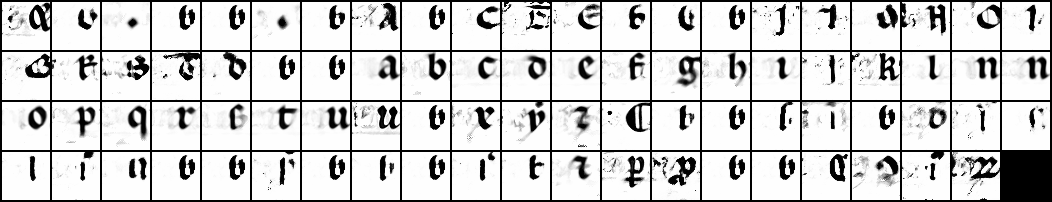

In [ ]:
trainer = load_pretrained_model(join(RUNS, 'iwcp_south_north/train/'), device=None)
display(plot_sprites(trainer, color=False))

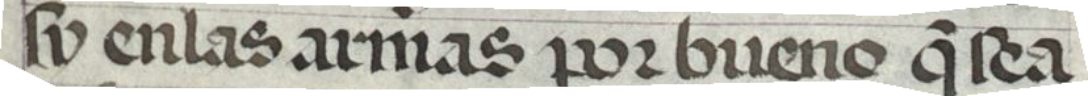

In [ ]:
display_inference(trainer)

## Finetuned models

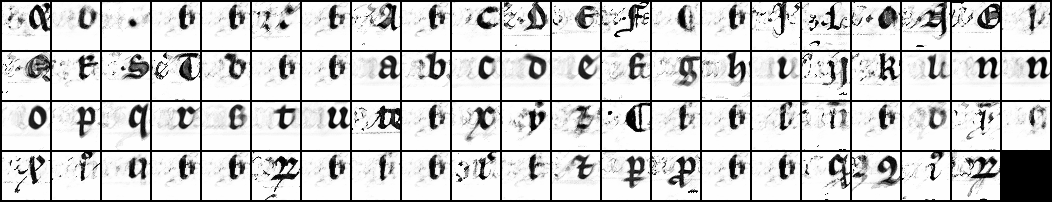

In [ ]:
# Load the pretrained model
NT3_state_dict = torch.load('/content/learnable-scriber/runs/iwcp_south_north/finetune/Arras-861/model.pth', map_location=torch.device('cpu'))
trainer.model.load_state_dict(NT3_state_dict)

# Display the result image (convert to PIL Image if necessary)
display(plot_sprites(trainer, color = False))

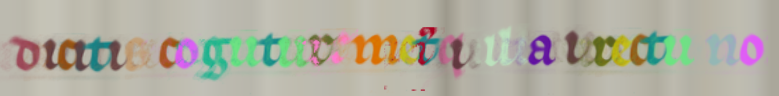

In [ ]:
display_inference(trainer, min_index=448, max_index=484) #The indices correspond to the specific document in the dataset